<div class='bar_title'></div>

*Data Driven Decisions in Practice (D3IP): Urban Analytics*

# Case Study: Predicting AirBnB Accomodation Prices

Gunther Gust & Nikolai Stein

Data Driven Decisions (D3) Group <br>
Center for Artificial Intelligence & Data Science <br>



<img src="images/d3.png" style="width:20%; float:left;" />

<img src="images/CAIDASlogo.png" style="width:20%; float:left;" />

Complete the case study outlined by the steps below. Remember to always comment your code and document your findings so that your notebook is easy to read and follow! (Apart from correctness, the style of the notebook will also affect your grade!)



# PART 1: Data Loading and Exploratory Data Analysis

Insructions:

* Load the `airbnb.geojson` file into this notebook as a geodataframe
* Explore the content of each column of the geodataframe using methods of your choice (descriptive statistics, plots etc.). Describe your findings in the markdown cells.
* Create a plot that displays the location of the airbnb listings and the price. Add a basemap of San Diego to the plot.

In [4]:
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib.pyplot as plt 
import seaborn as sns
import contextily as cx

In [11]:
# Load the geodataframe <insert your code here>....
db = gpd.read_file("airbnb_listings.geojson")

#exploring the dataset
db.head()
#db.tail()

,accommodates,bathrooms,bedrooms,beds,rt_Private_room,rt_Shared_room,pg_Condominium,pg_House,pg_Other,pg_Townhouse,price,geometry
0,5,2.0,2.0,2.0,0,0,0,1,0,0,425.0,POINT (-117.12971 32.75399)
1,6,1.0,2.0,4.0,0,0,1,0,0,0,205.0,POINT (-117.25253 32.78421)
2,2,1.0,1.0,1.0,1,0,0,0,0,0,99.0,POINT (-117.14121 32.75327)
3,2,1.0,1.0,1.0,1,0,0,1,0,0,72.0,POINT (-117.15269 32.93110)
4,2,1.0,1.0,1.0,1,0,0,1,0,0,55.0,POINT (-117.21870 32.74202)


These are the variables you should analyze and later use to predict the `price`:

In [ ]:

variable_names = [
    "accommodates",  # Number of people it accommodates
    "bathrooms",  # Number of bathrooms
    "bedrooms",  # Number of bedrooms
    "beds",  # Number of beds
    # Below are binary variables, 1 True, 0 False
    "rt_Private_room",  # Room type: private room
    "rt_Shared_room",  # Room type: shared room
    "pg_Condominium",  # Property group: condo
    "pg_House",  # Property group: house
    "pg_Other",  # Property group: other
    "pg_Townhouse",  # Property group: townhouse
]

# PART 2 Feature Engineering: Get points-of-interest (POIs) and prepare them

Instructions:

* Use the method `features_from_address()` of osmnx to download POIs of the type `amenity` (select the types of amenities to include from this list here: https://wiki.openstreetmap.org/wiki/Key:amenity)
* Pay attention to set the `dist` parameter to an appropiate value 

In [ ]:
import osmnx as ox

In [28]:
# Download the POI data <your code here> ...
pois = ox.features_from_address("San Diego, USA", dist = 5000, tags = {"amenity" : ["bar", "atm", "cafe", "restaurant"]})

In [31]:
pois.head(5)

addr:city addr:housenumber addr:postcode addr:state  \
element_type osmid                                                            
node         286316702  San Diego              721         92101         CA   
             297819169  San Diego              222         92101         CA   
             339167501        NaN              NaN           NaN        NaN   
             339168755        NaN              NaN           NaN        NaN   
             353135501        NaN              NaN           NaN        NaN   

                          addr:street     amenity            name  \
element_type osmid                                                  
node         286316702     9th Avenue  restaurant  Wicked Chicken   
             297819169  Island Avenue  restaurant        Cafe 222   
             339167501            NaN         atm     Wells Fargo   
             339168755            NaN  restaurant         Barbusa   
             353135501            NaN  restaurant    The Wits End   

                                           geometry changing_table  \
element_type osmid                                                   
node         286316702  POINT (-117.15631 32.71273)            NaN   
             297819169  POINT (-117.16267 32.71056)            yes   
             339167501  POINT (-117.16850 32.72288)            NaN   
             339168755  POINT (-117.16850 32.72478)            NaN   
             353135501  POINT (-117.16126 32.74724)            NaN   

                                   cuisine  ... nrhp:criteria  \
element_type osmid                          ...                 
node         286316702                 NaN  ...           NaN   
             297819169  breakfast;sandwich  ...           NaN   
             339167501                 NaN  ...           NaN   
             339168755             italian  ...           NaN   
             353135501                 NaN  ...           NaN   

                       nrhp:inscription_date old_name owner protection_title  \
element_type osmid                                                             
node         286316702                   NaN      NaN   NaN              NaN   
             297819169                   NaN      NaN   NaN              NaN   
             339167501                   NaN      NaN   NaN              NaN   
             339168755                   NaN      NaN   NaN              NaN   
             353135501                   NaN      NaN   NaN              NaN   

                       ref:nrhp source_ref fast_food access male  
element_type osmid                                                
node         286316702      NaN        NaN       NaN    NaN  NaN  
             297819169      NaN        NaN       NaN    NaN  NaN  
             339167501      NaN        NaN       NaN    NaN  NaN  
             339168755      NaN        NaN       NaN    NaN  NaN  
             353135501      NaN        NaN       NaN    NaN  NaN  

[5 rows x 136 columns]

Data cleaning: The resulting `pois` geodataframe may have a composite row index. In addition, some POIs may be of a strange element_type. You can use the following code to eliminate these issues.

In [32]:
# Clean the POI data
pois.reset_index(inplace=True) # reset the index of the data frame
pois = pois[pois.element_type=="node"] # eliminate all POIs that are not of the type "node"
pois.head() # check the results

,element_type,osmid,addr:city,addr:housenumber,addr:postcode,addr:state,addr:street,amenity,name,geometry,...,nrhp:criteria,nrhp:inscription_date,old_name,owner,protection_title,ref:nrhp,source_ref,fast_food,access,male
0,node,286316702,San Diego,721,92101,CA,9th Avenue,restaurant,Wicked Chicken,POINT (-117.15631 32.71273),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node,297819169,San Diego,222,92101,CA,Island Avenue,restaurant,Cafe 222,POINT (-117.16267 32.71056),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node,339167501,NaN,NaN,NaN,NaN,NaN,atm,Wells Fargo,POINT (-117.16850 32.72288),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node,339168755,NaN,NaN,NaN,NaN,NaN,restaurant,Barbusa,POINT (-117.16850 32.72478),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node,353135501,NaN,NaN,NaN,NaN,NaN,restaurant,The Wits End,POINT (-117.16126 32.74724),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Instructions:
* Plot the POIs spatially (use again a background map of San Diego)
* When you use POIs of different amenity types, color the POIs differently

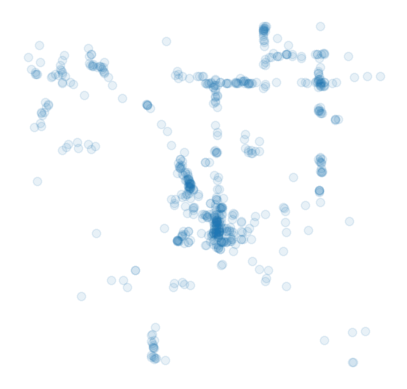

In [37]:
# <Your code here>
#pois.plot(alpha = 0.1)
# Setup figure and axis
f, ax = plt.subplots(1)
# Plot layer of polygons on the axis
ax = pois.plot(alpha = 0.1, ax=ax)
# Remove axis frames
ax.set_axis_off()
# Display
plt.show()

For each POI amenity type, create a kernel density estimation (KDE):
* Convert the `geometry` of the POI into a suitable coordinate data format (you may use the provided function `create_coordinate_array` for this)
* Feed the resulting coordinates into the `gaussian_kde` function and estimate the function
* Also convert the `geometry` of the Airbnb listings into the coordinate data format (you may use the provided function `create_coordinate_array` for this)
* Using the converted Airbnb geometries, compute the KDE for the locations of the Airbnb listings
* Add the KDE estimate as additional columns to your original airbnb geodataframe

In [ ]:
from scipy.stats import gaussian_kde

In [ ]:
# helper function to convert the geometries into a suitable coordinate format for the KDE
def create_coordinate_array(geometries): 
    x_values = []
    y_values = []

# Iterate through each row in the GeoDataFrame
    for multipoint in geometries:
        # Ensure the geometry is indeed MultiPoint; if it's just a single Point, wrap it in a list
        points = list(multipoint.geoms) if hasattr(multipoint, "geoms") else [multipoint]
        
        # For each Point in the MultiPoint, extract x and y values
        for point in points:
            x_values.append(point.x)
            y_values.append(point.y)

    # Optionally, convert the lists to numpy arrays for further processing
    x_values = np.array(x_values)
    y_values = np.array(y_values)

    # Rearrange data to create a 2D array of x and y coordinates
    xy = np.vstack([x_values,y_values])

    return xy


# Example Usage for the Airbnb geodataframe
airbnb_array = create_coordinate_array(airbnb.geometry)

In [ ]:
#<Your code here>

Create a spatial point plot(s) of the Airbnb listings and color the points according to the KDE estimates, in order to check your results.

In [ ]:
# <your code here>

# PART 3: Modeling and Analysis (aka Machine Learning)

Use your dataset generated in the previous steps to predict AirBnb prices

Instructions:

* Split your data set into training and validation data sets
* Define an error metric (or several)
* Train at least one machine learning model (e.g. random forest) 
* Tune the hyperparameters (if applicable for the model)
* Evaluate the accuracy of the predicted prices against actual prices
* Compare the performance of the previous models when using different input data sets (benchmarks). Make sure to include the naive benchmark of predicting always the mean price.

In [ ]:
from sklearn.model_selection import train_test_split

X = ""
y = ""

## Model 1: Trivial Baseline

In [ ]:
# Trivial baseline: Predict always the mean price 
# <your code here>

## Model 2: ...

In [ ]:
# <your code here>

## Model 3: ...